In [1]:
# --- Imports ---
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import defaultdict
import pickle

# reproducibility
np.random.seed(0)
random.seed(0)


In [3]:
class RecyclingGrid:
    def __init__(self, grid, start=None, max_steps=200):
        """grid: list of equal-length strings (each string is a row)."""
        self.grid = [list(r) for r in grid]
        self.h = len(self.grid)
        self.w = len(self.grid[0])
        self.max_steps = max_steps

        # find start if provided else first 'S' else (0,0)
        if start is None:
            found = None
            for i in range(self.h):
                for j in range(self.w):
                    if self.grid[i][j] == 'S':
                        found = (i, j)
                        break
                if found:
                    break
            start = found
        self.start = start or (0, 0)
        self.reset()

    def reset(self):
        # copy grid for dynamic changes
        self._grid = [row.copy() for row in self.grid]
        self.pos = tuple(self.start)
        self.steps = 0
        self.recyclables = set()
        for i in range(self.h):
            for j in range(self.w):
                if self._grid[i][j] == 'R':
                    self.recyclables.add((i, j))
        self.done = False
        return self._state()

    def _state(self):
        # create (row, col, bitmask) state
        if not hasattr(self, '_recycle_index'):
            self._recycle_index = {}
            k = 0
            for i in range(self.h):
                for j in range(self.w):
                    if self.grid[i][j] == 'R':
                        self._recycle_index[(i, j)] = k
                        k += 1
            self._num_recycles = k
        mask = 0
        for pos, k in self._recycle_index.items():
            if pos in self.recyclables:
                mask |= (1 << k)
        return (self.pos[0], self.pos[1], mask)

    def step(self, action):
        if self.done:
            raise RuntimeError("Episode has finished. Call reset().")
        r, c = self.pos
        if action == 0:  # up
            nr, nc = max(0, r - 1), c
        elif action == 1:  # right
            nr, nc = r, min(self.w - 1, c + 1)
        elif action == 2:  # down
            nr, nc = min(self.h - 1, r + 1), c
        elif action == 3:  # left
            nr, nc = r, max(0, c - 1)
        else:
            raise ValueError('Invalid action')

        cell = self._grid[nr][nc]
        reward = -0.1  # step penalty to encourage speed
        done = False

        if cell == 'H':
            reward = -10.0
            done = True
        elif cell == 'R' and (nr, nc) in self.recyclables:
            reward = 10.0
            self.recyclables.remove((nr, nc))
            self._grid[nr][nc] = '.'
            if len(self.recyclables) == 0:
                done = True

        # move agent
        self.pos = (nr, nc)
        self.steps += 1
        if self.steps >= self.max_steps:
            done = True

        self.done = done
        return self._state(), reward, done, {}

    def render(self):
        g = [row.copy() for row in self._grid]
        r, c = self.pos
        g[r][c] = 'A'
        print('\n'.join(''.join(row) for row in g))


In [5]:
class QLearningAgent:
    def __init__(self, actions, alpha=0.5, gamma=0.99, epsilon=0.2):
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(len(actions), dtype=float))

    def act(self, state, greedy=False):
        if (not greedy) and (np.random.rand() < self.epsilon):
            return int(np.random.choice(self.actions))
        q = self.Q[state]
        return int(np.argmax(q))

    def update(self, s, a, r, s2, done):
        qsa = self.Q[s][a]
        if done:
            target = r
        else:
            target = r + self.gamma * np.max(self.Q[s2])
        self.Q[s][a] = qsa + self.alpha * (target - qsa)


In [7]:
# Define a sample grid (adjust size and layout as you like)
grid = [
    'S.....',
    '..R.H.',
    '...R..',
    '.H....',
    '..R...'
]

env = RecyclingGrid(grid, max_steps=200)
actions = [0, 1, 2, 3]  # up, right, down, left

agent = QLearningAgent(actions, alpha=0.6, gamma=0.95, epsilon=0.2)


Episode 900/1000, recent avg reward: 28.05


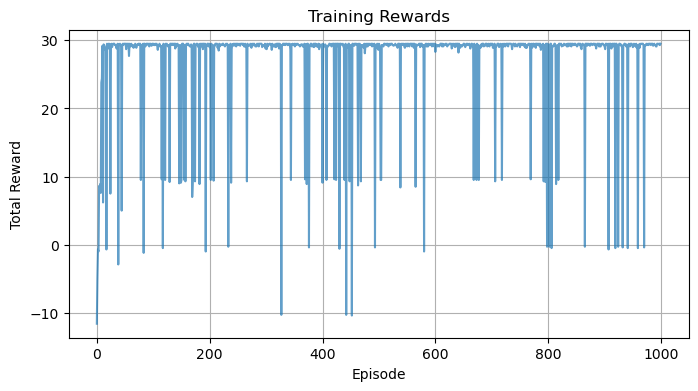

In [9]:
# Training parameters
episodes = 1000
rewards = []

for ep in range(episodes):
    state = env.reset()
    total_r = 0.0
    done = False
    while not done:
        a = agent.act(state)            # epsilon-greedy action
        s2, r, done, _ = env.step(a)    # take step
        agent.update(state, a, r, s2, done)
        state = s2
        total_r += r
    rewards.append(total_r)

    # slowly decay epsilon
    if ep % 50 == 0 and ep > 0:
        agent.epsilon = max(0.01, agent.epsilon * 0.995)

    # progress print
    if ep % 100 == 0:
        clear_output(wait=True)
        print(f"Episode {ep}/{episodes}, recent avg reward: {np.mean(rewards[-100:]):.2f}")

# Plot training rewards
plt.figure(figsize=(8,4))
plt.plot(rewards, alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.grid(True)
plt.show()


In [11]:
agent.epsilon = 0.0  # greedy for evaluation
eval_episodes = 5

for ep in range(eval_episodes):
    s = env.reset()
    path = [env.pos]
    total = 0.0
    done = False
    while not done:
        a = agent.act(s, greedy=True)
        s, r, done, _ = env.step(a)
        path.append(env.pos)
        total += r
    print(f"Episode {ep+1}: total reward = {total:.2f}")
    env.render()
    print('Path:', path)
    print('-' * 40)


Episode 1: total reward = 29.50
S.....
....H.
......
.H....
..A...
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 2)]
----------------------------------------
Episode 2: total reward = 29.50
S.....
....H.
......
.H....
..A...
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 2)]
----------------------------------------
Episode 3: total reward = 29.50
S.....
....H.
......
.H....
..A...
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 2)]
----------------------------------------
Episode 4: total reward = 29.50
S.....
....H.
......
.H....
..A...
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 2)]
----------------------------------------
Episode 5: total reward = 29.50
S.....
....H.
......
.H....
..A...
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 2)]
----------------------------------------


In [13]:
# Save Q-table to disk
with open('qtable_recycling.pkl', 'wb') as f:
    pickle.dump(dict(agent.Q), f)
print("Saved Q-table to qtable_recycling.pkl")

# To load later:
# with open('qtable_recycling.pkl', 'rb') as f:
#     loaded_Q = pickle.load(f)
# agent.Q = defaultdict(lambda: np.zeros(len(actions)), loaded_Q)


Saved Q-table to qtable_recycling.pkl
